In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import linalg as LA
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
from src import AutoEncoder, SmoothSailing, kappa

In [169]:
args = SimpleNamespace(batch_size=32, test_batch_size=1000, epochs=10,
                       lr=0.0001, momentum=0.5, seed=1, log_interval=100, 
                            beta_end=0.1,
                            beta_mid=0.005,
                            end_layer_size=256,
                            mid_layer_size=32,
                            noise_level=2)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [170]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [171]:
model = AutoEncoder(end_layer_size=args.end_layer_size, mid_layer_size=args.mid_layer_size).to(device)
model_reg = AutoEncoder(end_layer_size=args.end_layer_size, mid_layer_size=args.mid_layer_size).to(device)

In [172]:
m = torch.load('denoise_model3_2.0.pt', map_location=torch.device('cpu'))
m_reg = torch.load('denoise_model_reg3_2.0.pt', map_location=torch.device('cpu'))

In [173]:
model.load_state_dict(m)
model_reg.load_state_dict(m_reg)

<All keys matched successfully>

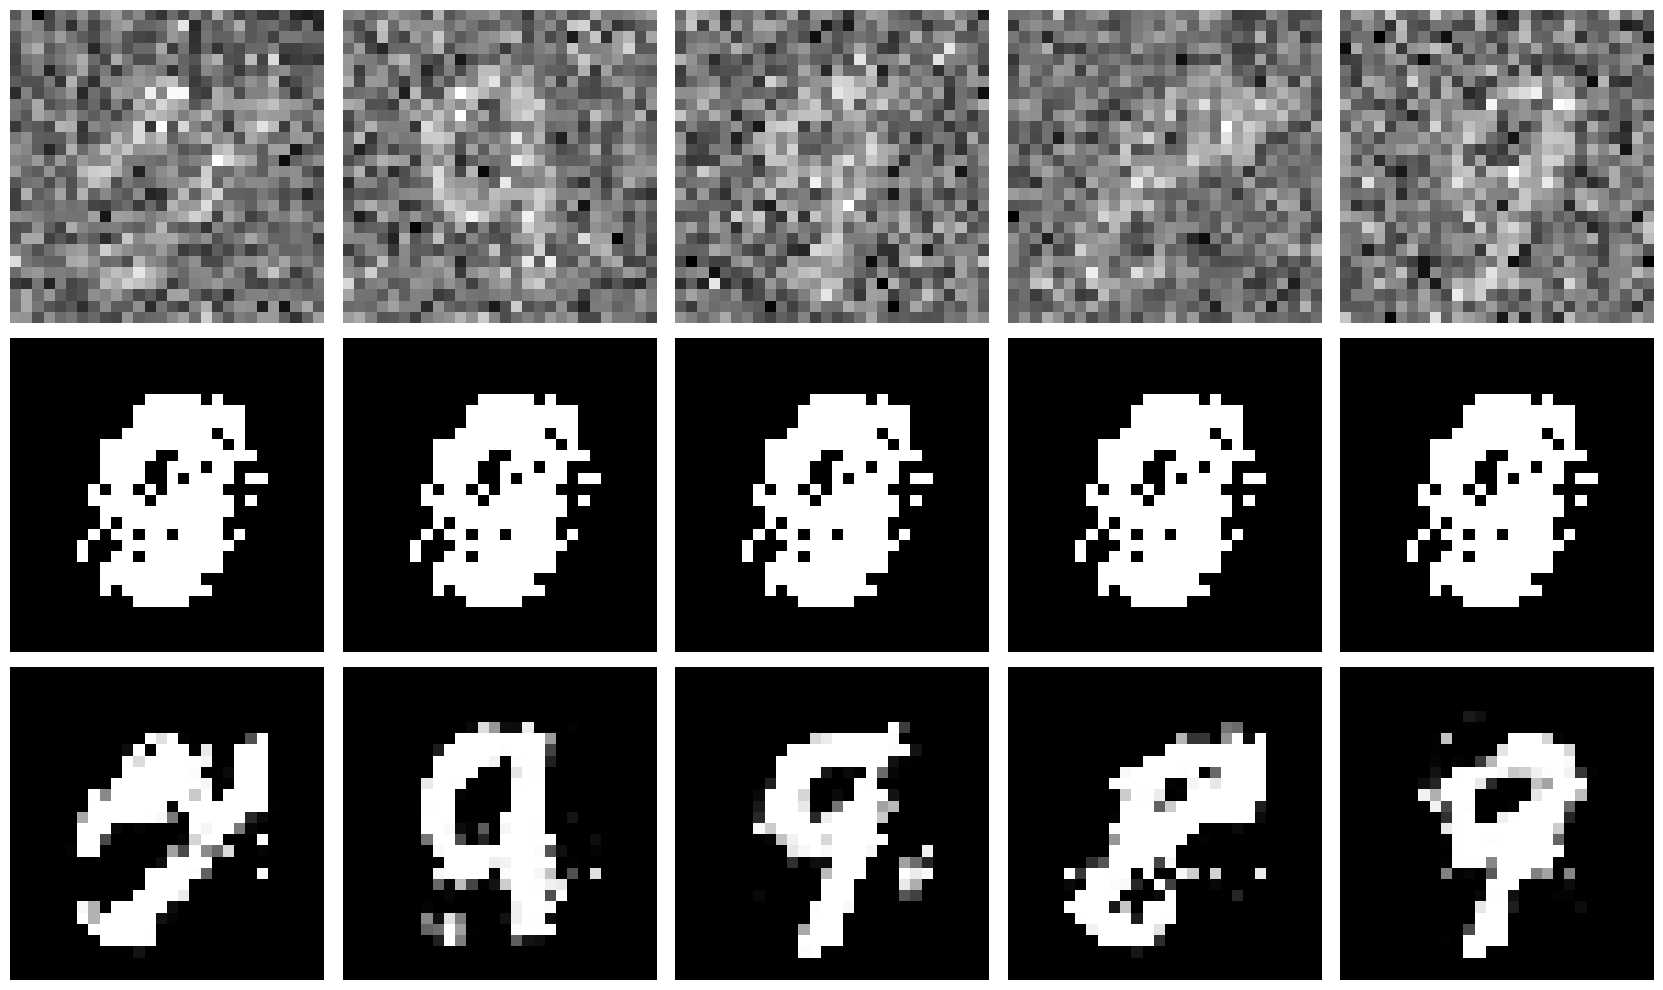

In [176]:
# plot denoised images
plt.figure(figsize=(60,10))

for i in range(5):
    data, train_labels = next(iter(train_loader))
    noisy_data = data[i][0] + args.noise_level * torch.randn(data[i][0].shape)
    output = model(noisy_data.view(-1, 28*28)).view(28, 28).cpu().detach().numpy()
    output_reg = model_reg(noisy_data.view(-1, 28*28)).view(28, 28).cpu().detach().numpy()

    plt.subplot(3, 18, i+1)
    plt.imshow(noisy_data.cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 18, i+19)
    plt.imshow(output, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 18, i+37)
    plt.imshow(output_reg, cmap='gray')
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('MNIST_denoising_32.png')
plt.show()
